# Part B

In [2]:
#1. Read and explore the data

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from sklearn.model_selection import train_test_split

# Update the path to where you have stored the dataset
dataset_url = "https://raw.githubusercontent.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection/master/Sarcasm_Headlines_Dataset.json"
data = pd.read_json(dataset_url, lines=True)

# Display the first 5 records to explore the dataset
data.head()

# Get basic information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [3]:
#2. Retain relevant columns

data = data[['is_sarcastic', 'headline']]
data.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [4]:
#3. Get length of each sentence

data['headline_length'] = data['headline'].apply(len)
data[['headline', 'headline_length']].head()

,headline,headline_length
0,thirtysomething scientists unveil doomsday clo...,61
1,dem rep. totally nails why congress is falling...,79
2,eat your veggies: 9 deliciously different recipes,49
3,inclement weather prevents liar from getting t...,52
4,mother comes pretty close to using word 'strea...,61


In [5]:
#4. Define parameters

max_length = 100  # Maximum length of a headline
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
embedding_dim = 100

In [6]:
#5. Get indices for words

tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(data['headline'])
word_index = tokenizer.word_index
total_words = len(word_index)
sequences = tokenizer.texts_to_sequences(data['headline'])
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [7]:
#6. Create features and labels 

X = padded
y = np.array(data['is_sarcastic'])

In [8]:
#7. Get vocabulary size 

vocab_size = len(word_index) + 1  # Adding 1 because of reserved 0 index

In [9]:
#8. Create a weight matrix using GloVe embeddings 

# Load the GloVe word embeddings
glove_file = 'glove.6B/glove.6B.100d.txt'  # Ensure you update the path to the GloVe file
embeddings_index = {}
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [10]:
#9. Define and compile a Bidirectional LSTM model.

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     3,088,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,088,600 (11.78 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,088,600 (11.78 MB)

In [11]:
#10. Fit the model and check the validation accuracy

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=2)

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val, verbose=2)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

Epoch 1/10
627/627 - 29s - 47ms/step - accuracy: 0.7551 - loss: 0.4969 - val_accuracy: 0.8148 - val_loss: 0.3996
Epoch 2/10
627/627 - 14s - 22ms/step - accuracy: 0.8257 - loss: 0.3838 - val_accuracy: 0.8050 - val_loss: 0.4275
Epoch 3/10
627/627 - 16s - 25ms/step - accuracy: 0.8558 - loss: 0.3332 - val_accuracy: 0.8571 - val_loss: 0.3286
Epoch 4/10
627/627 - 16s - 26ms/step - accuracy: 0.8672 - loss: 0.3084 - val_accuracy: 0.8551 - val_loss: 0.3312
Epoch 5/10
627/627 - 15s - 24ms/step - accuracy: 0.8811 - loss: 0.2784 - val_accuracy: 0.8629 - val_loss: 0.3129
Epoch 6/10
627/627 - 16s - 26ms/step - accuracy: 0.8912 - loss: 0.2592 - val_accuracy: 0.8706 - val_loss: 0.3081
Epoch 7/10
627/627 - 18s - 29ms/step - accuracy: 0.9056 - loss: 0.2309 - val_accuracy: 0.8675 - val_loss: 0.3272
Epoch 8/10
627/627 - 17s - 27ms/step - accuracy: 0.9137 - loss: 0.2127 - val_accuracy: 0.8635 - val_loss: 0.3285
Epoch 9/10
627/627 - 16s - 25ms/step - accuracy: 0.9205 - loss: 0.1994 - val_accuracy: 0.8724 - 

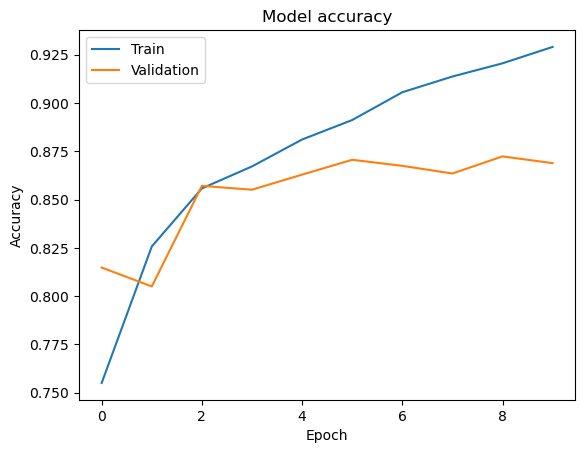

In [12]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

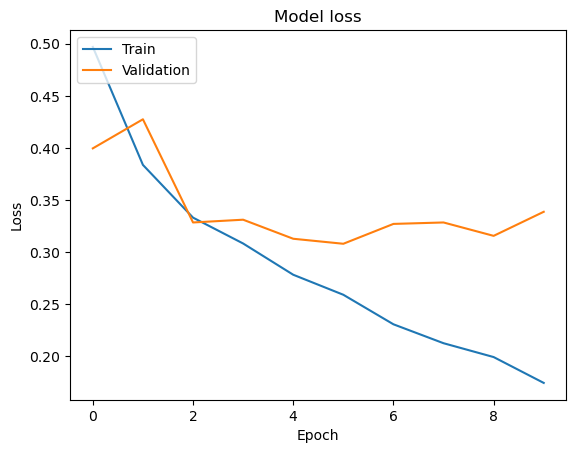

In [13]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()